# Topological Uncertainty and Topological Difference

**Goal:** We want to experimentally test the differences between Topological Uncertainty (TD) and Topological DIfference (TD).

### Import libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import from external libraries.

In [2]:
import numpy as np
import matplotlib.pylab as plt

Import our implementation to compute topological uncertainty

In [3]:
import utils.utils_graphs as ug
import utils.utils_notebook as unb
import utils.utils_tda as utda

2022-02-23 14:33:57.689175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 14:33:57.689190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2. Topological uncertainty on tensorflow neural network

For this section, you need `tensorflow 2` installed.

In [4]:
import tensorflow as tf

## 2.1 A First example

We briefly show how you can use TU on a simple tensorflow sequential network. We showcase this using the MNIST dataset.

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_train = x_train.reshape(len(x_train), 784)

x_test = x_test / 255.0
x_test = x_test.reshape(len(x_test), 784)

labels = np.unique(y_train)
nlabels = len(labels)

We know build a tensorflow model with 2 hidden layers with 64 and 16 units, respectively.

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[x_train.shape[1]]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(nlabels, activation='softmax'),
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer='adam'
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 51,450
Trainable params: 51,450
Non-trainable params: 0
_________________________________________________________________


2022-02-23 14:33:59.089815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:33:59.090028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 14:33:59.090052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-23 14:33:59.090073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-23 14:33:59.090093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Now we compile and train the model. It should easily reach ~ 98% of (training) accuracy.

In [7]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

num_epochs = 10
model.fit(x_train, y_train, epochs=num_epochs)

Epoch 1/10
   1/1875 [..............................] - ETA: 6:11 - loss: 2.2866 - accuracy: 0.2500

/home/felix/.cache/pypoetry/virtualenvs/topologicaluncertainty-FuTyNJF2-py3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 1s 630us/step - loss: 0.3157 - accuracy: 0.9092
Epoch 2/10
1875/1875 [==============================] - 1s 637us/step - loss: 0.1412 - accuracy: 0.9576
Epoch 3/10
1875/1875 [==============================] - 1s 631us/step - loss: 0.1019 - accuracy: 0.9692
Epoch 4/10
1875/1875 [==============================] - 1s 624us/step - loss: 0.0803 - accuracy: 0.9755
Epoch 5/10
1875/1875 [==============================] - 1s 629us/step - loss: 0.0655 - accuracy: 0.9796
Epoch 6/10
1875/1875 [==============================] - 1s 631us/step - loss: 0.0546 - accuracy: 0.9827
Epoch 7/10
1875/1875 [==============================] - 1s 627us/step - loss: 0.0470 - accuracy: 0.9848
Epoch 8/10
1875/1875 [==============================] - 1s 638us/step - loss: 0.0400 - accuracy: 0.9873
Epoch 9/10
1875/1875 [==============================] - 1s 628us/step - loss: 0.0338 - accuracy: 0.9892
Epoch 10/10
1875/1875 [==============================] - 1s 629us/step - lo

We briefly check that it did not grossly overfit (this experiment is just for illustrative purpose, we do not aim to have a fine-tuned network). In the following cell, `accuracy` should be about 97%.

In [8]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 444us/step - loss: 0.1100 - accuracy: 0.9701


[0.10996943712234497, 0.9700999855995178]

Now, for **each class** and **only the final layer**, we will:
- Build the activation graphs for each training observation. Note: there are 6,000 observations per class in MNIST; using all of them may be overkill. In the following, we will only use 100 reference observations for each class, which turns out to be sufficient.
- Extract topological features (called _persistence diagrams_) from these activation graphs (which, in our specific setting, can be interpreted as extracting maximum spanning trees from the graphs). 
- Average these persistence diagrams to have a compact summary of how our training observations (for each class) activated the network. This average is encoded by a Fréchet mean, a.k.a. barycenter, of the corresponding diagrams.

Actually, all these three steps are handled by the function `bary_of_set_from_deep_model(model, x, layers_id)`, available from `utils.utils_tda` (imported as `utda` in this notebook). In this function, 
- `model` is our tensorflow model we have trained above.
- `x` is a set of points from which we compute diagrams and average them.
- `layers_id` is a subset of the model layers. Setting `layers_id=None` implies taking all layers into account. Here, as we have 3 layers, and we want to consider only the last one, we set `layers_id=[2]`.

In [9]:
n_obs_per_class = 500

# Take n_obs_per_class observation from each class in x_train:
xs = [x_train[np.where(y_train == ell)][:n_obs_per_class] for ell in labels]

# Now we get the corresponding barycenters.
layers_id = [2]
all_barycenters = [utda.barycenters_of_set_from_deep_model(model, x, layers_id=layers_id) for x in xs]

# and the corresponding mean adjacency matrices

all_mean_adjacency_matrices = [utda.mean_adjacency_matrices_from_deep_model(model, x, layers_id=layers_id) for x in xs]

In [10]:
print(np.max(np.array(all_mean_adjacency_matrices)))
np.array(all_mean_adjacency_matrices).shape

8.250318


(10, 1, 16, 10)

Now, given a new observation, we can get the class assigned by our `model` to it, and compute its distance to the barycenter of this class to check if something weird is happening. 

Let us take, for instance, the first 10 observations of the test set. The first one represents a 7.

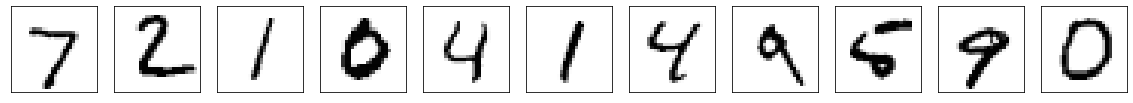

In [11]:
n_new_obs = 11
new_obs = x_test[:n_new_obs]
fig, axs = plt.subplots(1, n_new_obs, figsize=(20,3))
for i,ax in enumerate(axs):
    ax.imshow(new_obs[i].reshape(28,28), cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])

What does our model predict there?

In [12]:
predicted_classes = np.argmax(model.predict(new_obs), axis=-1)
predictions = model.predict(new_obs)
confidences = np.max(predictions, axis=-1)
true_classes = y_test[:n_new_obs]
for i in range(n_new_obs):
    print("class predicted: %s (with confidence = %s%%) --- True label: %s" 
          %(predicted_classes[i], np.round(100*confidences[i], 1), true_classes[i]))
    print("***")

class predicted: 7 (with confidence = 100.0%) --- True label: 7
***
class predicted: 2 (with confidence = 100.0%) --- True label: 2
***
class predicted: 1 (with confidence = 100.0%) --- True label: 1
***
class predicted: 0 (with confidence = 100.0%) --- True label: 0
***
class predicted: 4 (with confidence = 95.9%) --- True label: 4
***
class predicted: 1 (with confidence = 100.0%) --- True label: 1
***
class predicted: 4 (with confidence = 99.9%) --- True label: 4
***
class predicted: 9 (with confidence = 99.9%) --- True label: 9
***
class predicted: 6 (with confidence = 42.2%) --- True label: 5
***
class predicted: 9 (with confidence = 100.0%) --- True label: 9
***
class predicted: 0 (with confidence = 100.0%) --- True label: 0
***


Let's plot the confidences per class and overlay them with the prediction (red dot). 

In [13]:
# print('Standard Confidence:\nPredicted classes: ', predicted_classes)
# plt.imshow(predictions)
# plt.scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
# plt.colorbar()
# print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

As we can see, our network is correct most of the time (unless one has been very unlucky with the random seed used for training) and is quite confident in its predictions.

Now, what's the _Topological uncertainty_ of these new observations? That is, what is the distance between the persistence diagrams (of the activation graphs) of these new observations and the barycenters of the corresponding class?

In [14]:
# First, we compute the diagram of this new observation
utda.topological_uncertainty(model, new_obs, all_barycenters, layers_id=layers_id, all_classes=False)

array([0.09877641, 0.30692895, 0.22726883, 0.11995644, 0.2955722 ,
       0.08616724, 0.15358407, 0.11431551, 0.22220269, 0.31984942,
       0.07965519])

Topological Uncertainty:
Predicted classes:  [7 2 1 0 4 1 4 9 6 9 0]
x-axis: class labels,
y-axis: input samples
red dots: predicted class


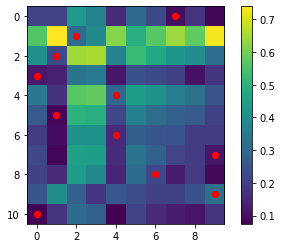

In [15]:
#predicted_classes = np.argmax(model.predict(new_obs), axis=-1)
print('Topological Uncertainty:\nPredicted classes: ', predicted_classes)
TU_pred_class = utda.topological_uncertainty(model, new_obs, all_barycenters, layers_id=layers_id, all_classes=False)
TU = utda.topological_uncertainty(model, new_obs, all_barycenters, layers_id=layers_id, all_classes=True)
im = plt.imshow(TU)
plt.colorbar(im)
plt.scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

In [16]:
# utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=False)
# all_mean_adjacency_matrices[1].shape

Topological Difference:
Predicted classes:  [7 2 1 0 4 1 4 9 6 9 0]
x-axis: class labels,
y-axis: input samples
red dots: predicted class


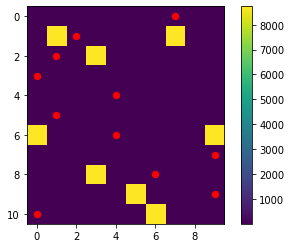

In [36]:
print('Topological Difference:\nPredicted classes: ', predicted_classes)
TD_pred_class = utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=False, absolute_value=True)
TD, diags, adjacency_matrices, matrix_diff = utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=True, absolute_value=True)
im = plt.imshow(TD)
plt.colorbar(im)
plt.scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

In [18]:
TD.shape

(11, 10)

In [37]:
#np.max(np.abs(np.array(diags)))
print('Max value of adjacency matrices:', np.max(np.array(adjacency_matrices)))
np.array(adjacency_matrices).shape

Max value of adjacency matrices: 9.417572


(11, 1, 16, 10)

In [38]:
# print(np.array(all_mean_adjacency_matrices[1][0]).shape)
# (adjacency_matrices[2][0] - all_mean_adjacency_matrices[1][0]).shape

In [41]:
print(np.array(matrix_diff).shape)
np.max(np.array(matrix_diff))

(10, 11, 1, 16, 10)


20.120087

In [40]:
print(np.array(diags).shape)
np.max(np.array(diags))

(10, 11, 1, 15)


131072.00000094093

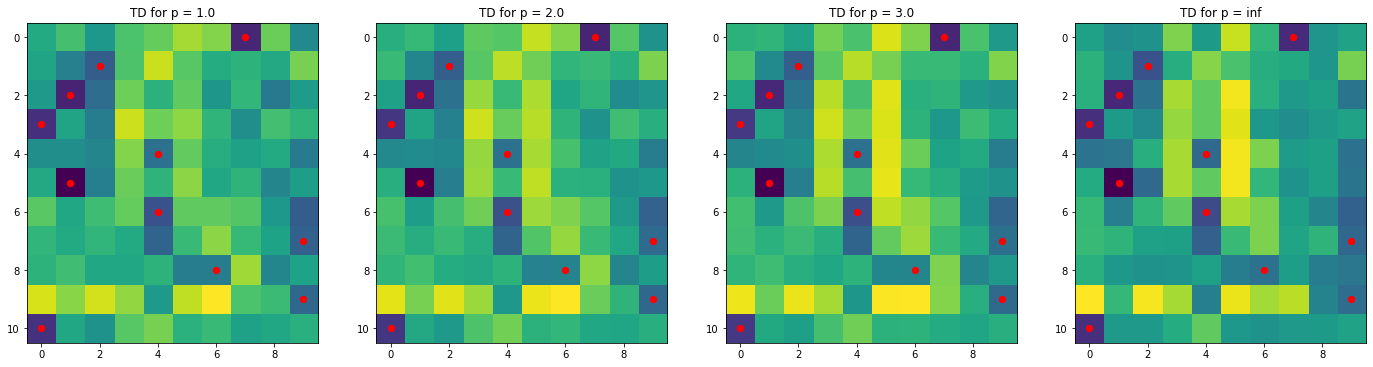

In [29]:
# Let's see the effect of the choice of 'p' in [1,+inf].
p_s = [1., 2., 3., np.inf]
fig, axs = plt.subplots(1, len(p_s), figsize=(24, 6))
for ix,p in enumerate(p_s):
    TD, diags, _, _ = utda.topological_difference(model, new_obs, all_mean_adjacency_matrices, layers_id=layers_id, p=p, all_classes=True, absolute_value=True)
    im = axs[ix].imshow(TD)
    axs[ix].scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
    axs[ix].set_title(f'TD for p = {p}')
    #plt.colorbar(im)
#fig.colorbar(axs)

In [ ]:
np.array(all_mean_adjacency_matrices).shape

In [ ]:
# We now define cumulative version of TU, where we sum up the TU w.r.t. each non-predicted class and subtract the TU w.r.t. the predicted class.

TU[list(range(len(predicted_classes))), predicted_classes] *= -1
# TU *= -1
TU_cumulative = np.sum(TU, axis=1)


#We do the same for TD:
TD[list(range(len(predicted_classes))), predicted_classes] *= -1
# TD *= -1
TD_cumulative = np.sum(TD, axis=1)
print('TU cumulative:\n', TU_cumulative)
print('TD cumulative:\n', TD_cumulative)

To get an idea of what these values represent, let us look at how our model reacts to Out-of-distribution data coming from the `Fashion MNIST` dataset.

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist

(x_train_fmnist, y_train_fmnist) = fmnist.load_data()[0]
x_train_fmnist = x_train_fmnist / 255.0
x_train_fmnist = x_train_fmnist.reshape(len(x_train_fmnist), 784)

nplots = 10
fix, axs = plt.subplots(1, nplots, figsize=(20,3))

for i, ax in enumerate(axs):
    (ax.imshow(x_train_fmnist[i].reshape(28,28), cmap='Greys'), ax.set_xticks([]), ax.set_yticks([]))

In [ ]:
ood_samples = x_train_fmnist[:10]
predictions = model.predict(ood_samples)
predicted_classes_ood = np.argmax(predictions, axis=-1)
confidences = np.max(predictions, axis=-1)

In [ ]:
# print('Standard Confidence:\nPredicted classes: ', predicted_classes)
# plt.imshow(predictions)
# plt.scatter(x=predicted_classes, y=list(range(len(predicted_classes))), color='red', s=40)
# plt.colorbar()
# print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

In [ ]:
print('Topological Uncertainty\nPredicted classes: ', predicted_classes)
TU_ood_pred_class = utda.topological_uncertainty(model, ood_samples, all_barycenters, layers_id=layers_id, all_classes=False)
TU_ood = utda.topological_uncertainty(model, ood_samples, all_barycenters, layers_id=layers_id, all_classes=True)
plt.imshow(TU_ood)
plt.scatter(x=predicted_classes_ood, y=list(range(len(predicted_classes))), color='red', s=40)
plt.colorbar()
print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

In [ ]:
print('Topological Difference:\nPredicted classes: ', predicted_classes)
TD_ood_pred_class = utda.topological_difference(model, ood_samples, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=False, absolute_value=True)
TD_ood, _ = utda.topological_difference(model, ood_samples, all_mean_adjacency_matrices, layers_id=layers_id, all_classes=True, absolute_value=True)
plt.imshow(TD_ood)
plt.scatter(x=predicted_classes_ood, y=list(range(len(predicted_classes))), color='red', s=40)
plt.colorbar()
print('x-axis: class labels,\ny-axis: input samples\nred dots: predicted class')

In [ ]:
# # We now define cumulative version of TU, where we sum up the TU w.r.t. each non-predicted class and subtract the TU w.r.t. the predicted class.

# TU_ood[list(range(len(predicted_classes))), predicted_classes] *= -1
# # TU_ood *= -1
# TU_ood_cumulative = np.sum(TU_ood, axis=1)


# #We do the same for TD:
# TD_ood[list(range(len(predicted_classes))), predicted_classes] *= -1
# # TD_ood *= -1
# TD_ood_cumulative = np.sum(TD_ood, axis=1)

# print('TU:\n', TU_pred_class)
# print('TU ood:\n', TU_ood_pred_class)
# print('TU cumulative:\n', TU_cumulative)
# print('TU ood cumulative:\n', TU_ood_cumulative)
# print('TD:\n', TD_pred_class)
# print('TD ood:\n', TD_ood_pred_class)
# print('TD cumulative:\n', TD_cumulative)
# print('TD ood cumulative:\n', TD_ood_cumulative)

In [ ]:
# fig, axs = plt.subplots(2, 3, figsize=(24, 6))
# x = list(range(len(TU_pred_class)))

# axs[0,0].scatter(x, TU_pred_class, color='blue', alpha=0.75, label='TU')
# axs[0,1].scatter(x, TU_cumulative, color='blue', alpha=0.75, label='TU cumulative')
# # axs[0,0].scatter(x, TU_ood_pred_class, color='red', alpha=0.75, label='TU ood')
# # axs[0,0].scatter(x, TU_ood_cumulative, color='black', alpha=0.75, label='TU ood cumulative')

# axs[0,0].scatter(x, TD_pred_class, color='green', alpha=0.75, label='TD')
# axs[0,1].scatter(x, TD_cumulative, color='green', alpha=0.75, label='TD cumulative')
# # axs[0,1].scatter(x, TD_ood_pred_class, color='red', alpha=0.75, label='TD ood')
# # axs[0,1].scatter(x, TD_ood_cumulative, color='black', alpha=0.75, label='TD ood cumulative')

# # axs[1,0].scatter(x, TU_pred_class, color='blue', alpha=0.75, label='TU')
# # axs[1,0].scatter(x, TU_cumulative, color='green', alpha=0.75, label='TU cumulative')
# axs[1,0].scatter(x, TU_ood_pred_class, color='red', alpha=0.75, label='TU ood')
# axs[1,1].scatter(x, TU_ood_cumulative, color='red', alpha=0.75, label='TU ood cumulative')

# # axs[1,1].scatter(x, TD_pred_class, color='blue', alpha=0.75, label='TD')
# # axs[1,1].scatter(x, TD_cumulative, color='green', alpha=0.75, label='TD cumulative')
# axs[1,0].scatter(x, TD_ood_pred_class, color='black', alpha=0.75, label='TD ood')
# axs[1,1].scatter(x, TD_ood_cumulative, color='black', alpha=0.75, label='TD ood cumulative')

# axs[0,2].scatter(x, TU_ood_pred_class - TU_pred_class, color='black', alpha=0.75, label='TU ood - TU')
# axs[0,2].scatter(x, TD_ood_pred_class - TD_pred_class, color='red', alpha=0.75, label='TD ood - TD')

# axs[1,2].scatter(x, TU_ood_cumulative - TU_cumulative, color='black', alpha=0.75, label='TU ood cum - TU cum')
# axs[1,2].scatter(x, TD_ood_cumulative - TD_cumulative, color='red', alpha=0.75, label='TD ood cum - TD cum')

# axs[0,0].legend(fontsize=12)
# axs[0,1].legend(fontsize=12)
# axs[1,0].legend(fontsize=12)
# axs[1,1].legend(fontsize=12)
# axs[0,2].legend(fontsize=12)
# axs[1,2].legend(fontsize=12)

# plt.show()

As one can see, these values are much higher (except perhaps for the 9th image). This way, topological uncertainty can be used as a way to detect out-of-distribution samples. One may wonder if this could be read in the confidence of the network directly...

In [ ]:
ood_confidences = np.max(model.predict(ood_samples), axis=-1)
print(ood_confidences)

For most predictions, the network remains extremely confident in its predictions (while, of course, the prediction itself does not make sense)! Thus, confidence cannot be used as a reliable way to detect Out-of-Distribution samples while TU can help there.